Prova a automatizzare la selezione della linea sotto tramite l'immagine a colori \
nell'ultimo box c'è la selezione automatizzata

In [59]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math

Load video

In [60]:
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_3" / "Recording_3_normal_speed.mp4"
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 227.0


Define range for mask

In [61]:
# Define the range for light brown color in HSV
lower_brown = np.array([00, 30, 100])
upper_brown = np.array([20, 200, 255])

# Define the range for rose color in HSV
lower_rose = np.array([150, 30, 200])
upper_rose = np.array([180, 200, 255])

Define tolerance for horizontal line detection

In [62]:
# Tolleranza in radianti (5 gradi)
tolerance = np.deg2rad(5)

get frame

In [63]:
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 10)
ret, image_color = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

Apply mask

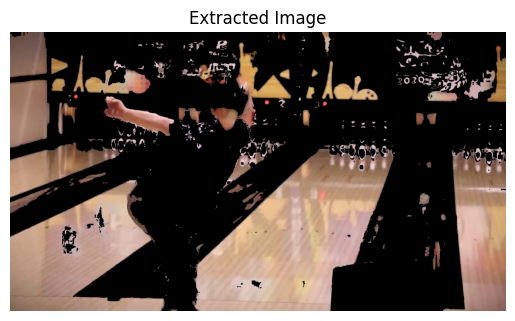

In [64]:
# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

# Create masks for brown and rose colors
mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
mask_rose = cv2.inRange(hsv_image, lower_rose, upper_rose)

# Combine the masks
combined_mask = cv2.bitwise_or(mask_brown, mask_rose)

# apply brown and rose mask
extracted_image = cv2.bitwise_and(image_color, image_color, mask=combined_mask)

# Show the extracted image
plt.imshow(cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB))
plt.title("Extracted Image")
plt.axis('off')
plt.show()

Cut the bottom part

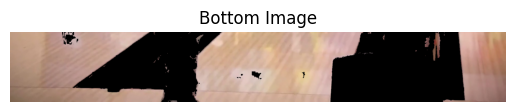

In [65]:
# Crop the bottom part of the image
limit_y = math.floor(3/4*extracted_image.shape[0])
bottom_image = extracted_image[limit_y:extracted_image.shape[0], 0:extracted_image.shape[1]]
plt.imshow(cv2.cvtColor(bottom_image, cv2.COLOR_BGR2RGB))
plt.title("Bottom Image")
plt.axis('off')
plt.show()

Get edges

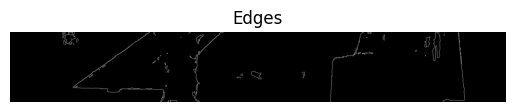

In [66]:
# Convert the bottom image to grayscale
gray_image = cv2.cvtColor(bottom_image, cv2.COLOR_BGR2GRAY)

# Compute Otsu's threshold 
otsu_thresh, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Set lower and upper thresholds relative to Otsu's threshold
lower = 0.5 * otsu_thresh
upper = 1.5 * otsu_thresh

# get edges
edges = cv2.Canny(gray_image, lower, upper)

# Show the edges
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.axis('off')
plt.show()

Get lines

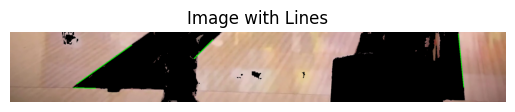

In [67]:
# Apply Probabilistic Hough Line Transform (allow to set minLineLength and maxLineGap)
min_line_length = 50
max_line_gap = 10 
lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=min_line_length, maxLineGap=max_line_gap) 

# Draw the lines on the image
image_with_lines = np.copy(bottom_image)
if lines_p is not None:
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the image with lines
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Image with Lines")
plt.axis('off')
plt.show()

Convert the lines in the form (rho, theta)

In [68]:
'''
Sructure of lines_p:
(x1, y1, x2, y2) are the coordinates of the two end points of the line segment
I want to convert them to the form rho,theta in order to easly detect the horizontal lines
'''
def convert_to_rho_theta(x1, y1, x2, y2):
    """
    Convert a line from (x1, y1, x2, y2) format to (rho, theta).
    """
    # Compute the line angle (in radians) and find the normal angle
    theta = np.arctan2(y2 - y1, x2 - x1) + np.pi / 2  # Normal angle

    # Compute rho using the normal equation
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)

    # Ensure rho is positive by adjusting theta accordingly
    if rho < 0:
        rho = -rho
        theta += np.pi  # Shift by 180 degrees to maintain equivalence

    return rho, theta

# Convert all lines to (rho, theta)
if lines_p is not None:
    rho_theta_lines = []
    for line in lines_p:
        x1, y1, x2, y2 = line[0]  # Extract line coordinates
        rho, theta = convert_to_rho_theta(x1, y1, x2, y2)
        rho_theta_lines.append((rho, theta))



Get horizontal lines

Number of horizontal lines: 1


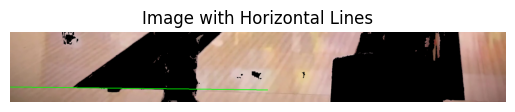

In [69]:
# Filtra le linee orizzontali
if rho_theta_lines is not None:
    horizontal_lines = [line for line in rho_theta_lines if abs(line[1] - np.pi/2) <= tolerance]
    print(f"Number of horizontal lines: {len(horizontal_lines)}")
    
    # Draw the horizontal lines on the image
    image_with_horizontal_lines = np.copy(bottom_image)

    for line in horizontal_lines:
        rho, theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image_with_horizontal_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
        

    # Show the image with horizontal lines
    plt.imshow(cv2.cvtColor(image_with_horizontal_lines, cv2.COLOR_BGR2RGB))
    plt.title("Image with Horizontal Lines")
    plt.axis('off')
    plt.show()

Try to automatize the detection

Number of horizontal lines: 1
i: 0


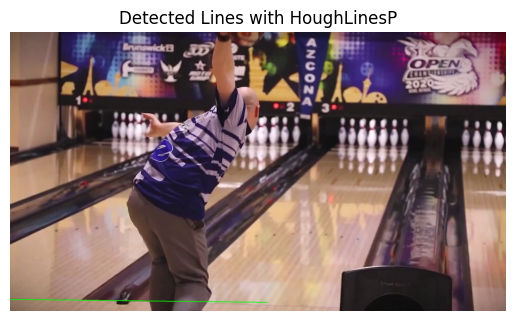

In [ ]:
# Define the range for light brown color in HSV
lower_brown = np.array([00, 30, 100])
upper_brown = np.array([20, 200, 255])

# Define the range for rose color in HSV
lower_rose = np.array([150, 30, 200])
upper_rose = np.array([180, 200, 255])

# Tolleranza in radianti (5 gradi)
tolerance = np.deg2rad(5)

num_horizontal_lines = 0 # numero di linee orizzontali trovate
i = 0   # indice per scorrere i frames

while num_horizontal_lines != 1: # finchè non trovo una sola linea orizzontale ---- PUO' NON ESSERE LA COSA OTTIMALE, INTANTO SEMBRA FUNZIONARE
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, image_color = cap.read()
    if not ret:
        print("Failed to read the frame")
        cap.release()
        exit()

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

    # Create masks for brown and rose colors
    mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
    mask_rose = cv2.inRange(hsv_image, lower_rose, upper_rose)

    # Combine the masks
    combined_mask = cv2.bitwise_or(mask_brown, mask_rose)

    # apply brown and rose mask
    extracted_image = cv2.bitwise_and(image_color, image_color, mask=combined_mask)

    # Crop the bottom part of the image
    limit_y = math.floor(3/4*extracted_image.shape[0])
    bottom_image = extracted_image[limit_y:extracted_image.shape[0], 0:extracted_image.shape[1]]

    # Convert the bottom image to grayscale
    gray_image = cv2.cvtColor(bottom_image, cv2.COLOR_BGR2GRAY)

    # Compute Otsu's threshold 
    otsu_thresh, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Set lower and upper thresholds relative to Otsu's threshold
    lower = 0.5 * otsu_thresh
    upper = 1.5 * otsu_thresh

    # get edges
    edges = cv2.Canny(gray_image, lower, upper)

    # Apply Probabilistic Hough Line Transform (allow to set minLineLength and maxLineGap)
    min_line_length = 50
    max_line_gap = 10 
    lines_p = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=min_line_length, maxLineGap=max_line_gap) 

    # Convert all lines to (rho, theta) RICORDATI DI AGGIUNGERE LA FUNZIONE CHE STAI USANDO CHE POI NON TI FUNZIONA UN CAZZO E BESTEMMI
    if lines_p is not None:
        rho_theta_lines = []
        for line in lines_p:
            x1, y1, x2, y2 = line[0]  # Extract line coordinates
            rho, theta = convert_to_rho_theta(x1, y1, x2, y2)
            rho_theta_lines.append((rho, theta))

    # Filtra le linee orizzontali
    if rho_theta_lines is not None:
        horizontal_lines = [line for line in rho_theta_lines if abs(line[1] - np.pi/2) <= tolerance]
        print(f"Number of horizontal lines: {len(horizontal_lines)}")
  
    num_horizontal_lines = len(horizontal_lines)
    print('i:', i)
    i += 1

# Create a copy of the original image to draw lines on
line_image_horizontal = np.copy(image_color)

for line in horizontal_lines:
        rho, theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_image_horizontal, (x1, y1 + limit_y), (x2, y2 + limit_y), (0, 255, 0), 2)
        
# Display the result
plt.imshow(cv2.cvtColor(line_image_horizontal, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines with HoughLinesP')
plt.axis('off')
plt.show()